In [1]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 저장 폴더 생성
os.makedirs("tfidf_plots", exist_ok=True)
os.makedirs("unique_keywords", exist_ok=True)

# 불용어
stopwords = set([
    '후보', '대선', '대통령', '정치', '선거', '민주당', '한덕수', '한동훈', '국민',
    '이재명', '김문수', '이준석', '있', '하', '되', '같', '이런', '그런', '대하',
    '이날', '아니', '기자', '더불어민주당', '국민의힘', '개혁신당', '민주노동당', '오전', '오후'
])

# 형태소 추출
def extract_tokens(tagged_text, allowed_tags={'NNG', 'NNP'}):
    tokens = []
    for item in str(tagged_text).split():
        if '(' in item and ')' in item:
            try:
                word, tag = item.rsplit('(', 1)
                tag = tag[:-1]
                if tag in allowed_tags and word not in stopwords:
                    tokens.append(word)
            except:
                continue
    return tokens

# 파일 불러오기
def load_token_list(path):
    df = pd.read_csv(path)
    all_tokens = []
    for text in df['tagged']:
        all_tokens += extract_tokens(text)
    return all_tokens

# TF 계산
def get_top_tf(tokens, top_n=50):
    counter = Counter(tokens)
    return counter.most_common(top_n)

# TF-IDF 계산
def get_top_tfidf(corpus_dict, target_key, top_n=50):
    corpus = [' '.join(tokens) for tokens in corpus_dict.values()]
    keys = list(corpus_dict.keys())
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    idx = keys.index(target_key)
    row = tfidf_matrix[idx].toarray().flatten()
    tfidf_scores = {feature_names[i]: row[i] for i in range(len(row))}
    top_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words, dict(zip(feature_names, row))

# 일치율 계산
def compute_overlap(tf_words, tfidf_words):
    tf_set = set(w for w, _ in tf_words)
    tfidf_set = set(w for w, _ in tfidf_words)
    return len(tf_set & tfidf_set) / len(tfidf_set)

# 경로
paths = {
    '이재명': 'https://raw.githubusercontent.com/hyeriiiiinnn/KORE208_team5/main/4.%20TF-IDF/lee_jaemyung_tagged_filtered.csv',
    '김문수': 'https://raw.githubusercontent.com/hyeriiiiinnn/KORE208_team5/main/4.%20TF-IDF/kim_moonsu_tagged_filtered.csv',
    '이준석': 'https://raw.githubusercontent.com/hyeriiiiinnn/KORE208_team5/main/4.%20TF-IDF/lee_junseok_tagged_filtered_ver2.csv'
}


In [2]:
# 분석 시작
tokens_dict = {k: load_token_list(v) for k, v in paths.items()}
results = []
tfidf_for_plot = {}
full_tfidf_scores = {}

for name in paths.keys():
    tf_top = get_top_tf(tokens_dict[name])
    tfidf_top, full_scores = get_top_tfidf(tokens_dict, name)
    overlap = compute_overlap(tf_top, tfidf_top)

    tf_words = [w for w, _ in tf_top]
    tfidf_words = [w for w, _ in tfidf_top]

    tfidf_for_plot[name] = dict(tfidf_top)
    full_tfidf_scores[name] = full_scores

    print(f"\n[{name}]")
    print(f"TF-TFIDF 상위 50 단어 일치율: {overlap:.2%}")
    print(f"TF 상위 단어: {tf_words}")
    print(f"TF-IDF 상위 단어: {tfidf_words}")

    results.append({
        '정치인': name,
        '일치율(%)': round(overlap * 100, 2),
        'TF 상위 단어': ', '.join(tf_words),
        'TF-IDF 상위 단어': ', '.join(tfidf_words)
    })

# CSV 저장
df_result = pd.DataFrame(results)
df_result.to_csv("TF_TFIDF_일치율_및_상위단어.csv", index=False, encoding='utf-8-sig')



[이재명]
TF-TFIDF 상위 50 단어 일치율: 88.00%
TF 상위 단어: ['말', '지지', '의원', '법원', '조사', '사건', '서울', '유세', '대표', '발언', '국회', '내란', '재판', '투표', '당', '보수', '사람', '공약', '지역', '대한민국', '정책', '경제', '일', '정부', '생각', '윤석열', '위원회', '선거법', '문제', '법관', '가능', '단일', '파기', '판결', '강조', '사진', '공직', '김', '진행', '뒤', '사법', '전', '국가', '필요', '여론', '탄핵', '공동', '운동', '통합', '시민']
TF-IDF 상위 단어: ['지지', '의원', '법원', '조사', '사건', '서울', '유세', '대표', '발언', '국회', '내란', '재판', '투표', '보수', '사람', '공약', '지역', '대한민국', '정책', '경제', '정부', '생각', '윤석열', '위원회', '선거법', '문제', '법관', '가능', '단일', '파기', '판결', '강조', '사진', '공직', '진행', '사법', '국가', '필요', '여론', '탄핵', '공동', '운동', '시민', '통합', '선고', '사회', '경기', '결과', '시장', '주장']

[김문수]
TF-TFIDF 상위 50 단어 일치율: 82.00%
TF 상위 단어: ['단일', '말', '당', '지지', '의원', '조사', '투표', '서울', '한', '대표', '경선', '윤석열', '유세', '국회', '사람', '여론', '생각', '윤', '보수', '위원장', '위원회', '뒤', '김', '대한민국', '대책', '탄핵', '공약', '당원', '결과', '발언', '사진', '입장', '전', '지도부', '사전', '내란', '중앙', '일', '토론', '대행', '비판', '주장', '문제', '앞', '총리', '계엄', '공동', '운동', 


정치인 간 TF-IDF 코사인 유사도:
        이재명     김문수    이준석
이재명  1.0000  0.8461  0.842
김문수  0.8461  1.0000  0.906
이준석  0.8420  0.9060  1.000


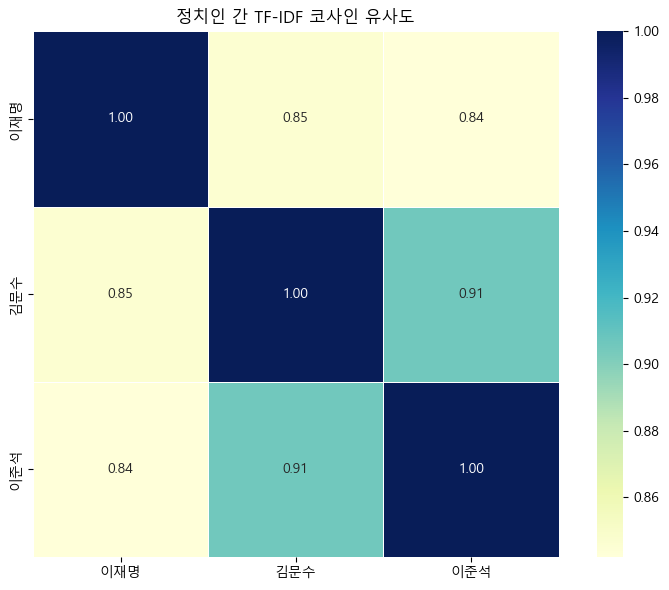

In [3]:
# 코사인 유사도
corpus = {name: ' '.join(tokens) for name, tokens in tokens_dict.items()}
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus.values())
names = list(corpus.keys())
similarity_matrix = cosine_similarity(tfidf_matrix)
df_sim = pd.DataFrame(similarity_matrix, index=names, columns=names)
print("\n정치인 간 TF-IDF 코사인 유사도:")
print(df_sim.round(4))
df_sim.to_csv("정치인_코사인_유사도.csv", encoding='utf-8-sig')

# 코사인 유사도 시각화 추가 (히트맵)
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df_sim, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, square=True)
plt.title("정치인 간 TF-IDF 코사인 유사도")
plt.tight_layout()
plt.savefig("코사인 유사도.png", dpi=300)
plt.show() 
plt.close()


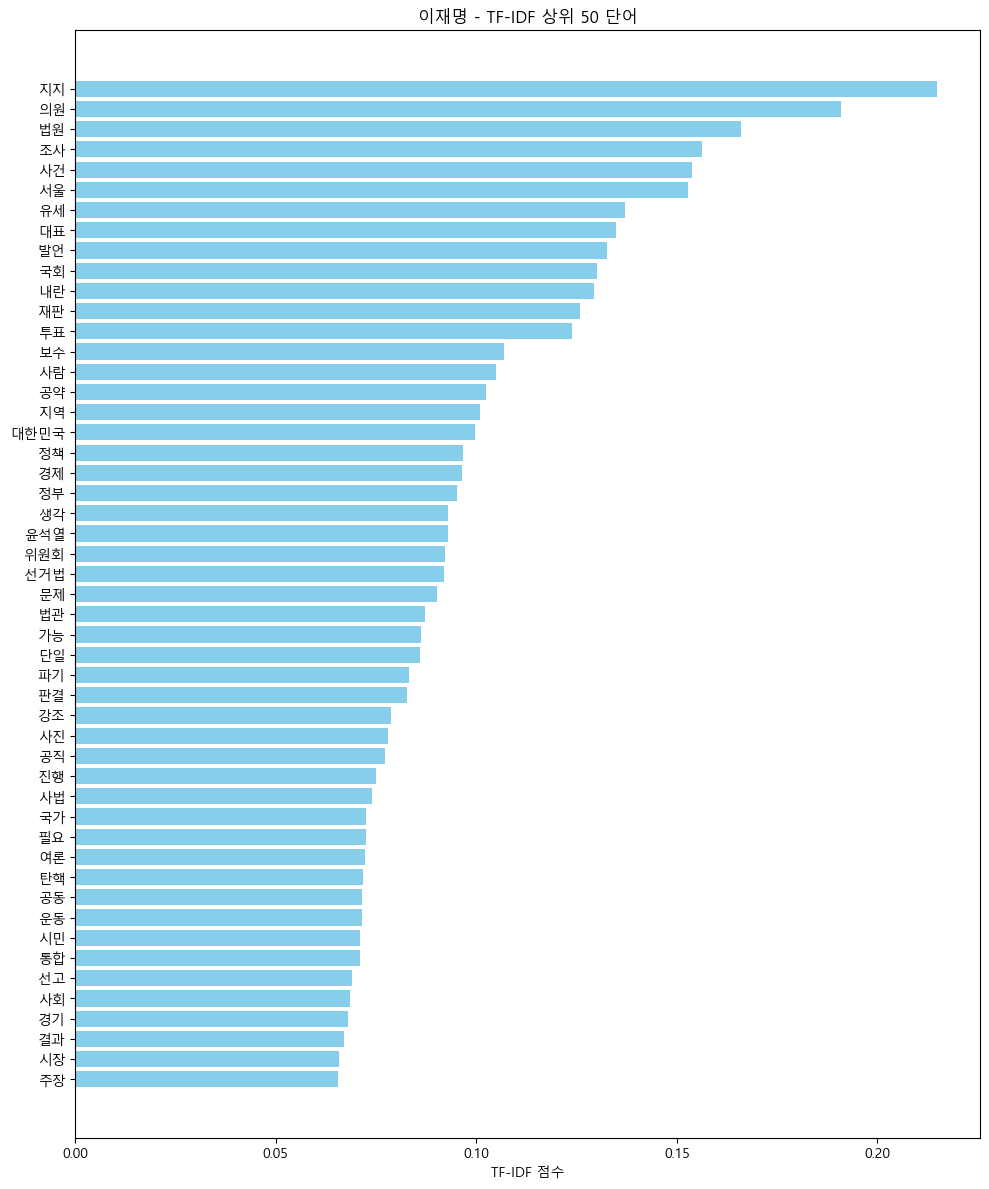

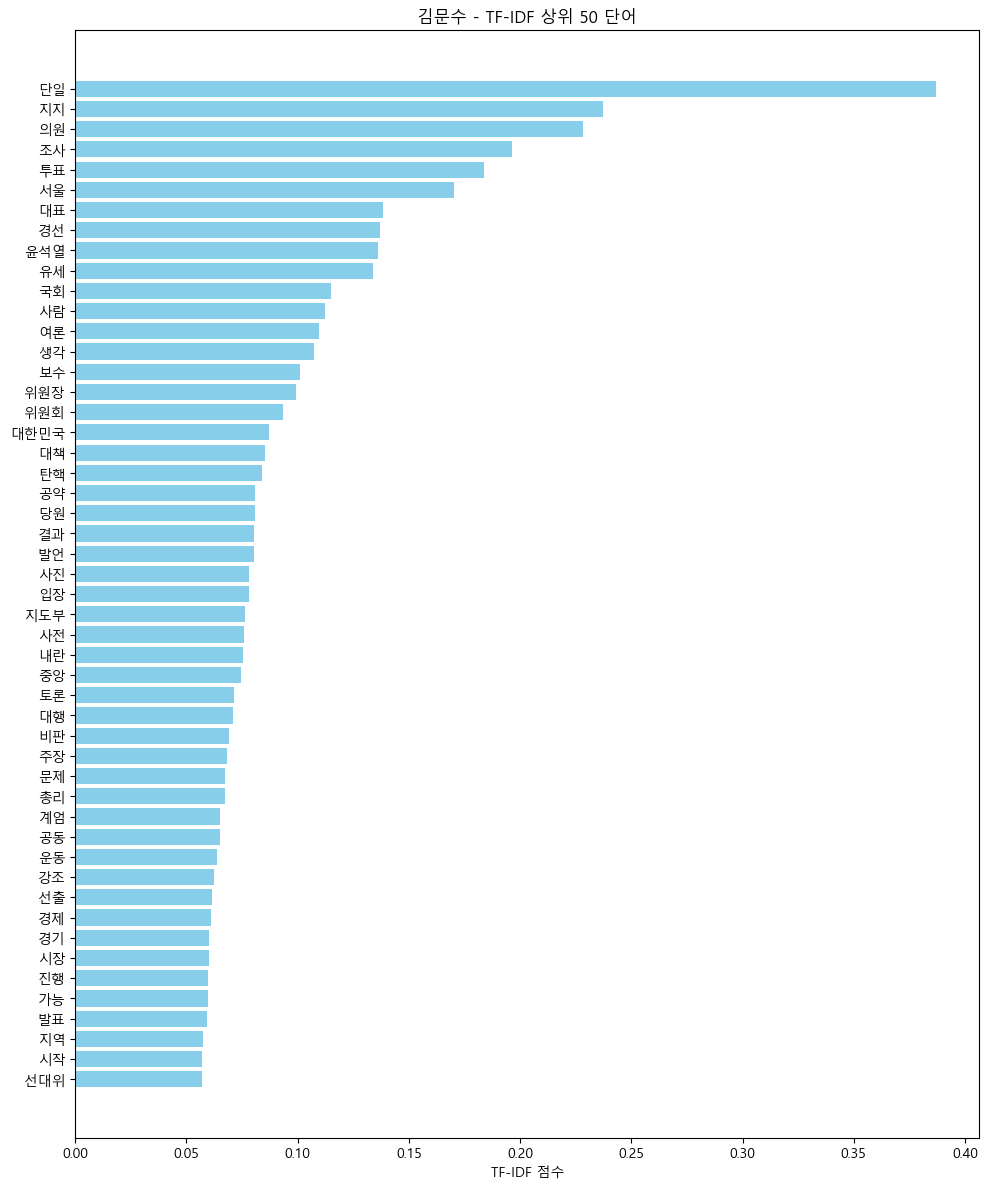

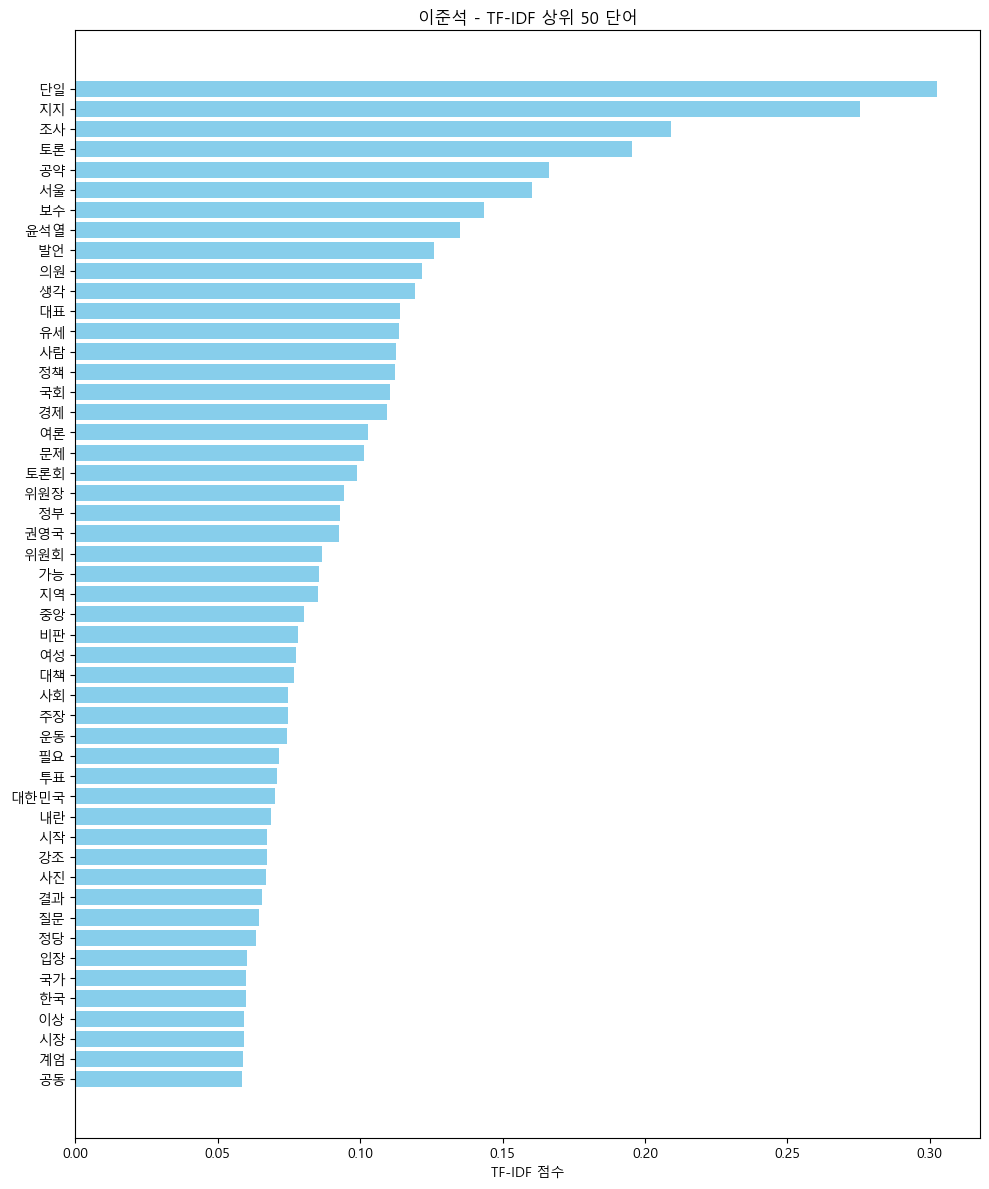

In [4]:
# TF-IDF 상위 단어 시각화 저장
for name, scores in tfidf_for_plot.items():
    sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    words, values = zip(*sorted_items)

    plt.figure(figsize=(10, 12))
    plt.barh(words[::-1], values[::-1], color="skyblue")
    plt.title(f"{name} - TF-IDF 상위 50 단어")
    plt.xlabel("TF-IDF 점수")
    plt.tight_layout()
    plt.savefig(f"{name} 상위 50 단어.png", dpi=300)
    plt.show() 
    plt.close()

In [5]:
# 고유 키워드 시각화 저장
all_words = {word for d in full_tfidf_scores.values() for word in d}

for name in full_tfidf_scores:
    others = set.union(*(set(full_tfidf_scores[n].keys()) for n in full_tfidf_scores if n != name))
    unique_words = set(full_tfidf_scores[name].keys()) - others

    unique_scores = {word: full_tfidf_scores[name][word] for word in unique_words}
    top_unique = sorted(unique_scores.items(), key=lambda x: x[1], reverse=True)[:20]

    if not top_unique:
        continue

    words, scores = zip(*top_unique)
    plt.figure(figsize=(8, 10))
    plt.barh(words[::-1], scores[::-1], color='salmon')
    plt.title(f"{name} - 고유 키워드 TF-IDF 상위 20")
    plt.xlabel("TF-IDF 점수")
    plt.tight_layout()
    plt.savefig(f"{name} 고유 키워드.png", dpi=300)
    plt.show() 
    plt.close()


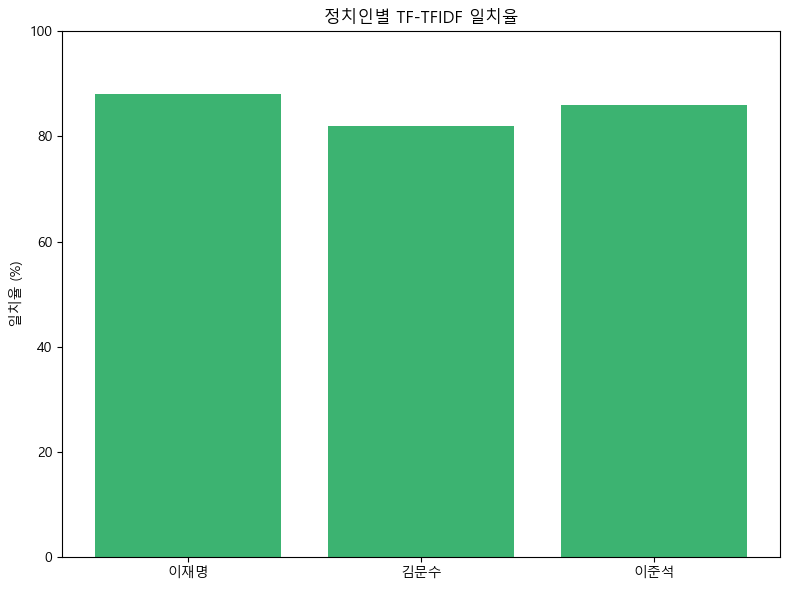

In [6]:
# TF-TFIDF 일치율 시각화
names = df_result['정치인']
overlaps = df_result['일치율(%)']

plt.figure(figsize=(8, 6))
plt.bar(names, overlaps, color='mediumseagreen')
plt.title("정치인별 TF-TFIDF 일치율")
plt.ylabel("일치율 (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig("정치인별 TF-TFIDF 일치율.png", dpi=300)
plt.show() 
plt.close()